# CIFAR10

In [181]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


# Define transformations for the training and test sets
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# transform = transforms.Compose(
#     [transforms.ToTensor(), normalize])

transform = transforms.Compose(
    [transforms.ToTensor()])

# Load the CIFAR-10 dataset
train_val_set = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.9 * len(train_val_set))
val_size = len(train_val_set) - train_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])

val_data = torch.stack([data for data, _ in val_set])

# Filter out planes from training data
train_data_l = []
train_labels = []
for data, label in train_set:
    if label != 0:
        train_data_l.append(data)
        train_labels.append(label)

# Keep all training data
train_data = torch.stack(train_data_l)
train_labels = torch.tensor(train_labels)

# Create data loaders for the training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

val_labels = torch.tensor([label for _, label in val_set])
val_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=128, shuffle=False)

test_labels = torch.tensor([label for _, label in test_set])
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# Print the sizes of the datasets
print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_set)}')

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40506
Validation set size: 5000
Test set size: 10000


In [139]:
print(torch.unique(torch.tensor(val_labels), return_counts=True))
print(torch.unique(torch.tensor(test_labels), return_counts=True))
print(torch.unique(torch.tensor(train_labels), return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([498, 492, 538, 492, 481, 530, 503, 463, 495, 508]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([4508, 4462, 4508, 4519, 4470, 4497, 4537, 4505, 4492]))


/var/folders/5f/82lq0pq96q17kcpzwpq3dlm40000gn/T/ipykernel_16304/435634570.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.unique(torch.tensor(val_labels), return_counts=True))
/var/folders/5f/82lq0pq96q17kcpzwpq3dlm40000gn/T/ipykernel_16304/435634570.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.unique(torch.tensor(test_labels), return_counts=True))
/var/folders/5f/82lq0pq96q17kcpzwpq3dlm40000gn/T/ipykernel_16304/435634570.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.unique(torch.tenso

In [140]:
val_data.shape

torch.Size([5000, 3, 32, 32])

In [182]:
# ------------------- -------------------
# Decrease amount of 1-9 digits in validation data set to 1/9 of its current amount
# ------------------- -------------------

indices_1_9 = val_labels != 0
indices_0 = val_labels == 0

print(len(val_data[indices_0]))
print(len(val_data[indices_1_9]))

# Randomly choose 500 examples from val_data[indices_1_9]
num_samples = 500
random_indices = torch.randperm(len(val_data[indices_1_9]))[:num_samples]
val_data_reduced = val_data[indices_1_9][random_indices]
val_labels_reduced = val_labels[indices_1_9][random_indices]

print(len(val_data_reduced))
print(len(val_labels_reduced))

print(torch.unique(val_labels_reduced, return_counts=True))

val_data_reduced = torch.cat((val_data_reduced, val_data[indices_0]), dim=0)
val_labels_reduced = torch.cat((val_labels_reduced, val_labels[indices_0]), dim=0)

print(len(val_data_reduced))
print(len(val_labels_reduced))

print(torch.unique(val_labels_reduced, return_counts=True))

# Reduced validation data loader
val_loader_reduced = DataLoader(TensorDataset(val_data_reduced, val_labels_reduced), batch_size=128, shuffle=True) # shuffle is optional

506
4494
500
500
(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([58, 36, 72, 50, 61, 54, 47, 59, 63]))
1006
1006
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([506,  58,  36,  72,  50,  61,  54,  47,  59,  63]))


# Autoencoders

## Definitions

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# BigAutoencoder
class BigAutoencoder(nn.Module):
    def __init__(self):
        super(BigAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (B, 32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (B, 32, 16, 16)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (B, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (B, 64, 8, 8)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (B, 128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # (B, 128, 4, 4)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, 32, 32)
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Autoencoder

In [184]:
# initialization
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# train 
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = batch.to(device)
        batch_reshaped = batch #.view(batch.size(0), -1)  # Flatten the batch
        
        optimizer.zero_grad()
        output = model(batch_reshaped)

        loss = criterion(output, batch_reshaped)
        loss.backward()
        optimizer.step()

    # validation loss
    with torch.no_grad():
        val_loss = 0
        for val_batch, _ in val_loader:
            val_batch = val_batch.to(device)
            val_batch_reshaped = val_batch #.view(val_batch.size(0), -1)  # Flatten the validation batch
            val_output = model(val_batch_reshaped)
            val_loss += criterion(val_output, val_batch_reshaped)
        val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train_loss: {loss.item():.4f}, Val_loss: {val_loss.item():.4f}')


Epoch [1/20], Train_loss: 0.0108, Val_loss: 0.0108
Epoch [2/20], Train_loss: 0.0095, Val_loss: 0.0095
Epoch [3/20], Train_loss: 0.0079, Val_loss: 0.0078
Epoch [4/20], Train_loss: 0.0060, Val_loss: 0.0068
Epoch [5/20], Train_loss: 0.0060, Val_loss: 0.0061
Epoch [6/20], Train_loss: 0.0055, Val_loss: 0.0058
Epoch [7/20], Train_loss: 0.0059, Val_loss: 0.0056
Epoch [8/20], Train_loss: 0.0049, Val_loss: 0.0056
Epoch [9/20], Train_loss: 0.0052, Val_loss: 0.0053
Epoch [10/20], Train_loss: 0.0058, Val_loss: 0.0055
Epoch [11/20], Train_loss: 0.0054, Val_loss: 0.0053
Epoch [12/20], Train_loss: 0.0046, Val_loss: 0.0050
Epoch [13/20], Train_loss: 0.0051, Val_loss: 0.0048
Epoch [14/20], Train_loss: 0.0042, Val_loss: 0.0048
Epoch [15/20], Train_loss: 0.0047, Val_loss: 0.0048
Epoch [16/20], Train_loss: 0.0048, Val_loss: 0.0047
Epoch [17/20], Train_loss: 0.0043, Val_loss: 0.0047
Epoch [18/20], Train_loss: 0.0048, Val_loss: 0.0047
Epoch [19/20], Train_loss: 0.0046, Val_loss: 0.0046
Epoch [20/20], Train_

In [156]:
criterion = nn.MSELoss()
a = [1, 2, 3]
y = [2, 2, 2]
l = []
x = criterion(torch.tensor(a, dtype=torch.float), torch.tensor(y, dtype=torch.float)).unsqueeze(0)
l.append(x)
l

[tensor([0.6667])]

In [185]:
thresholds = torch.linspace(0, 1, 20)

model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for val_batch, val_label in val_loader_reduced:
        for example, label in zip(val_batch, val_label):
            # example = example.view(-1)
            example = example.to(device)
            out = model(example)
            all_predictions.append(criterion(example, out).unsqueeze(0))
            all_labels.append(label.unsqueeze(0))

# concatenate all predictions and labels and change it to tensor
print(len(all_predictions), len(all_labels), len(val_data_reduced))
print(all_predictions)
all_predictions = torch.cat(all_predictions)
print(all_predictions)
all_labels = torch.cat(all_labels)

assert len(all_predictions) == len(all_labels)
assert len(all_predictions) == len(val_data_reduced)

# sort all_predictions and all_labels according to all_predictions
all_predictions, indices = torch.sort(all_predictions, descending=True)
sorted_labels = [all_labels[i] for i in indices.cpu()]
neg_pos_labels = torch.tensor([1 if label == 0 else 0 for label in sorted_labels])
sorted_labels = torch.tensor(sorted_labels)

tprs = []
fprs = []
f1_scores = []
precisions = []
recalls = []

# indices of 0
zeros_indices = sorted_labels == 0
# indices of other digits
other_indices = sorted_labels != 0
for threshold in thresholds:
    positive_class = all_predictions >= torch.quantile(all_predictions.cpu(), threshold)
    negative_class = all_predictions < torch.quantile(all_predictions.cpu(), threshold)

    tp = positive_class[zeros_indices].sum()
    fn = negative_class[zeros_indices].sum()
    tn = negative_class[other_indices].sum()
    fp = positive_class[other_indices].sum()

    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    fprs.append(fpr.cpu())
    tprs.append(tpr.cpu())

    f1_score = 2*tp/(2*tp + fp + fn)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)

    f1_scores.append(f1_score.cpu())
    precisions.append(precision.cpu())
    recalls.append(recall.cpu())

1006 1006 1006
[tensor([0.0051], device='mps:0'), tensor([0.0028], device='mps:0'), tensor([0.0072], device='mps:0'), tensor([0.0039], device='mps:0'), tensor([0.0052], device='mps:0'), tensor([0.0036], device='mps:0'), tensor([0.0040], device='mps:0'), tensor([0.0049], device='mps:0'), tensor([0.0019], device='mps:0'), tensor([0.0032], device='mps:0'), tensor([0.0047], device='mps:0'), tensor([0.0009], device='mps:0'), tensor([0.0026], device='mps:0'), tensor([0.0038], device='mps:0'), tensor([0.0023], device='mps:0'), tensor([0.0054], device='mps:0'), tensor([0.0043], device='mps:0'), tensor([0.0044], device='mps:0'), tensor([0.0082], device='mps:0'), tensor([0.0043], device='mps:0'), tensor([0.0029], device='mps:0'), tensor([0.0036], device='mps:0'), tensor([0.0041], device='mps:0'), tensor([0.0025], device='mps:0'), tensor([0.0047], device='mps:0'), tensor([0.0054], device='mps:0'), tensor([0.0024], device='mps:0'), tensor([0.0058], device='mps:0'), tensor([0.0036], device='mps:0')

In [186]:
# Find the threshold with the highest F1 score
best_threshold_index = torch.argmax(torch.tensor(f1_scores))
best_threshold = thresholds[best_threshold_index]
best_precision = precisions[best_threshold_index]
best_recall = recalls[best_threshold_index]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Precision at Best Threshold: {best_precision:.4f}')
print(f'Recall at Best Threshold: {best_recall:.4f}')

Best Threshold: 0.0000
Precision at Best Threshold: 0.5030
Recall at Best Threshold: 1.0000


In [187]:
positive_class = all_predictions >= torch.quantile(all_predictions.cpu(), thresholds[best_threshold_index])
negative_class = all_predictions < torch.quantile(all_predictions.cpu(), thresholds[best_threshold_index])

tp = positive_class[zeros_indices].sum()
fn = negative_class[zeros_indices].sum()
tn = negative_class[other_indices].sum()
fp = positive_class[other_indices].sum()

tpr = tp/(tp + fn)
fpr = fp/(fp + tn)

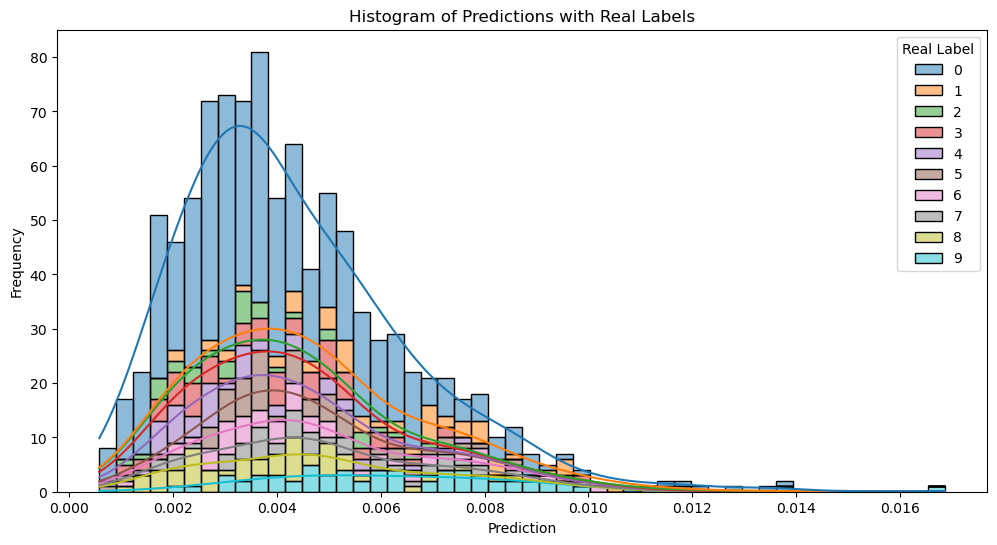

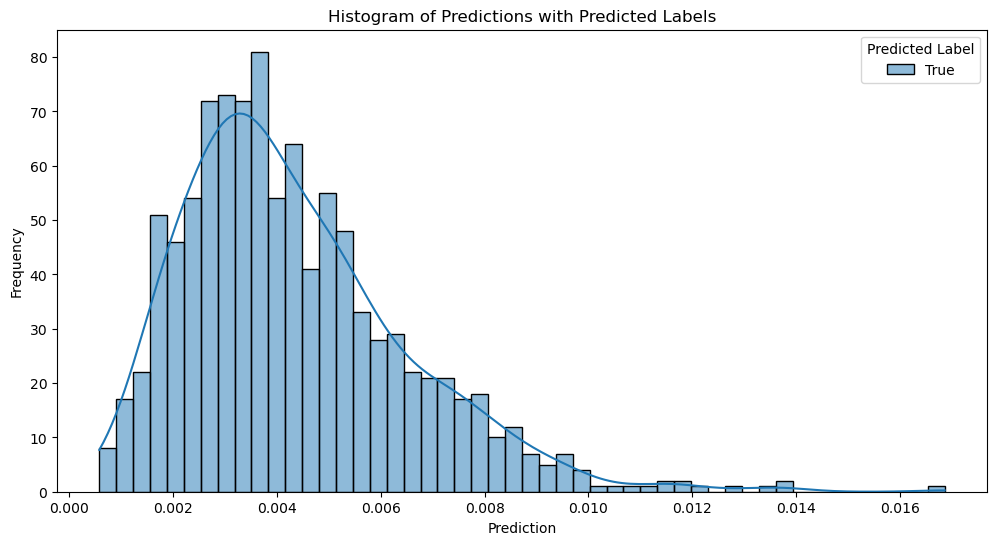

In [188]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Convert predictions and labels to numpy arrays for plotting
all_predictions_np = all_predictions.cpu().numpy()
sorted_labels_np = sorted_labels.cpu().numpy()
predicted_labels_np = positive_class.cpu().numpy()

# Create a DataFrame for easier plotting
data = {
    'Prediction': all_predictions_np,
    'Real Label': sorted_labels_np,
    'Predicted Label': predicted_labels_np
}

df = pd.DataFrame(data)

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Prediction', hue='Real Label', multiple='stack', palette='tab10', bins=50, kde=True)
plt.title('Histogram of Predictions with Real Labels')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Prediction', hue='Predicted Label', multiple='stack', palette='tab10', bins=50, kde=True)
plt.title('Histogram of Predictions with Predicted Labels')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.show()

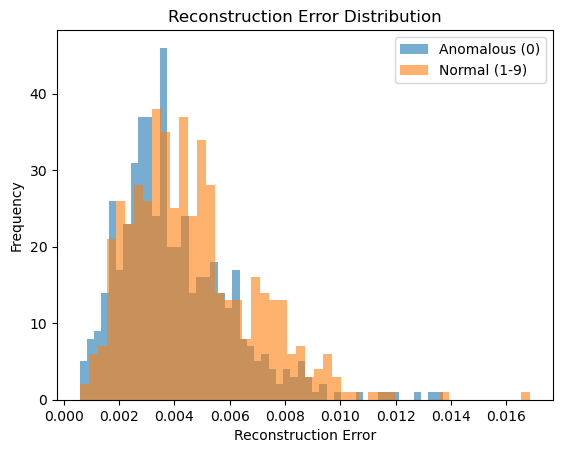

In [199]:
# Plot histogram of reconstruction errors
plt.figure()
plt.hist(all_predictions_np[sorted_labels_np == 0], bins=50, alpha=0.6, label="Anomalous (0)")
plt.hist(all_predictions_np[sorted_labels_np != 0], bins=50, alpha=0.6, label="Normal (1-9)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

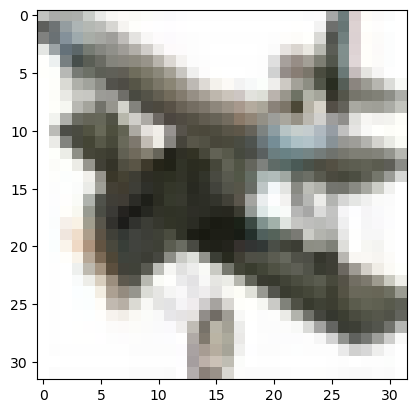

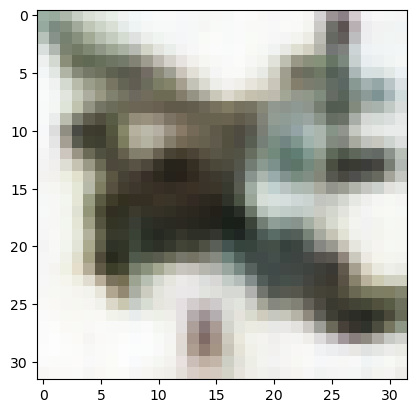

In [275]:
import numpy as np
import matplotlib.pyplot as plt

# Function to unnormalize and plot images
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def not_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(val_loader_reduced)
images, _ = next(dataiter)

# Show images
not_imshow(images[2])
# flattened_image = images[0].view(1, -1).to(device)
# imshow(model(flattened_image).view(3, 32, 32).cpu().detach())
not_imshow(model(images[2].unsqueeze(0).to(device)).cpu().detach().squeeze(0))